First, create a new conda environment named BI2025 and install the required packages from requirements.txt


In [22]:
#!conda create -n BI2025 python=3.11 -y
#!conda activate BI2025
#!pip install -r requirements.txt

In [23]:
#prevents the Windows timezone error
import time
time.tzname = ('Europe/Vienna', 'Europe/Vienna')

In [24]:
# Additional dependencies were added to the provided requirements file to ensure full reproducibility of the experiments,
# including provenance logging and visualization functionality.

In [25]:
# DO NOT MODIFY OR COPY THIS CELL!! 
# Note: 
# The only imports allowed are Python's standard library, pandas, numpy, scipy, matplotlib, seaborn and scikit-learn
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import plotly.express as px
import datetime
import typing
import requests
import time
import shutil
import json
from starvers.starvers import TripleStoreEngine

## Graph-based documentation preliminaries

In [26]:
# ---- Provenance safety switch ----
#PROVENANCE_ENABLED = False # set to True when server is stable

In [27]:
executed_by ='stud-id_12502707'  # Replace the digits after "id_" with your own student ID

Set your group and student IDs. Do this only once.

In [28]:
# group id for this project
group_id = '058'  # Replace the digits with your group id

# Students working on this notebook
student_a = 'stud-id_12502840'  # Replace the digits after "id_" with student A's student ID
student_b = 'stud-id_12502707'  # Replace the digits after "id_" with student B's student ID

In [29]:
# Roles. Don't change these values.
code_writer_role = 'code_writer'
code_executor_role = 'code_executor'

Setup the starvers API for logging your steps into our server-sided graph database.

In [30]:
get_endpoint = "https://starvers.ec.tuwien.ac.at/BI2025"
post_endpoint = "https://starvers.ec.tuwien.ac.at/BI2025/statements"
engine = TripleStoreEngine(get_endpoint, post_endpoint, skip_connection_test=True)

Use these prefixes in your notebooks. You can extend this dict with your prefixes of additional ontologies that you use in this notebook. Replace 00 with your group id

In [31]:
prefixes = {
    'xsd': 'http://www.w3.org/2001/XMLSchema#',
    'rdfs': 'http://www.w3.org/2000/01/rdf-schema#',
    'foaf': 'http://xmlns.com/foaf/0.1/',
    'prov': 'http://www.w3.org/ns/prov#',
    'sc': 'https://schema.org/',
    'cr': 'http://mlcommons.org/croissant/',
    'mls': 'http://www.w3.org/ns/mls#',
    'mlso': 'http://w3id.org/mlso',
    'siu': 'https://si-digital-framework.org/SI/units/',
    'siq': 'https://si-digital-framework.org/SI/quantities/',
    'qudt': 'http://qudt.org/schema/qudt/',
    '': f'https://starvers.ec.tuwien.ac.at/BI2025/{group_id}/',
}

prefix_header = '\n'.join([f'PREFIX {k}: <{v}>' for k, v in prefixes.items()]) + '\n\n'

Ontologies to use
* Provenance of the experiment process
    * PROV-O: 
        * doc: https://www.w3.org/TR/prov-o/
        * serialization: https://www.w3.org/ns/prov-o
* Data used and created
    * schema.org - Dataset: 
        * doc: https://schema.org/Dataset
        * serialization: https://schema.org/version/latest/schemaorg-current-https.ttl
    * Crossaint
        * doc: https://docs.mlcommons.org/croissant/docs/croissant-spec.html
        * serialization: https://github.com/mlcommons/croissant/blob/main/docs/croissant.ttl
* ML experiments performed
    * MLSO: 
        * doc: https://github.com/dtai-kg/MLSO
        * doc: https://dtai-kg.github.io/MLSO/#http://w3id.org/
        * serialization: https://dtai-kg.github.io/MLSO/ontology.ttl
* Measurements, Metrics, Units
    * QUDT
        * doc:https://qudt.org/
        * doc: https://github.com/qudt/qudt-public-repo
        * serialization: https://github.com/qudt/qudt-public-repo/blob/main/src/main/rdf/schema/SCHEMA_QUDT.ttl
    * SI Digital Framework
        * doc: https://github.com/TheBIPM/SI_Digital_Framework/blob/main/SI_Reference_Point/docs/README.md
        * doc: https://si-digital-framework.org/
        * doc: https://si-digital-framework.org/SI
        * serialization: https://github.com/TheBIPM/SI_Digital_Framework/blob/main/SI_Reference_Point/TTL/si.ttl
    * Quantities and Units
        * doc: https://www.omg.org/spec/Commons
        * serialization: https://www.omg.org/spec/Commons/QuantitiesAndUnits.ttl

Use this function to record execution times.

In [32]:
def now() -> str:
    """
    Returns the current time in ISO 8601 format with UTC timezone in the following format:
    YYYY-MM-DDTHH:MM:SS.sssZ
    """
    timestamp = datetime.datetime.now(datetime.timezone.utc)
    timestamp_formated = timestamp.strftime("%Y-%m-%dT%H:%M:%S.%f")[:-3]  +"Z"

    return timestamp_formated

Register yourself in the Knowledge Graph using ProvO. Change the given name, family name and immatriculation number to reflect your own data.

In [34]:
# Ontologies used: foaf, prov, IAO #skip
reigstration_triples_a = [
f':{student_a} rdf:type foaf:Person .',
f':{student_a} rdf:type prov:Agent .',
f':{student_a} foaf:givenName "Brikenda" .',
f':{student_a} foaf:familyName "Lajqi Pepshi" .',
f':{student_a} <http://vivoweb.org/ontology/core#identifier> :{student_a} .',
f':{student_a} rdf:type <http://purl.obolibrary.org/obo/IAO_0000578> .',
f':{student_a} <http://www.w3.org/2000/01/rdf-schema#label> "Immatriculation number" .',
f':{student_a} <http://purl.obolibrary.org/obo/IAO_0000219> "12502840"^^xsd:string .',
]

reigstration_triples_b = [
f':{student_b} rdf:type foaf:Person .',
f':{student_b} rdf:type prov:Agent .',
f':{student_b} foaf:givenName "Sofiana" .',
f':{student_b} foaf:familyName "Braho" .',
f':{student_b} <http://vivoweb.org/ontology/core#identifier> :{student_b} .',
f':{student_b} rdf:type <http://purl.obolibrary.org/obo/IAO_0000578> .',
f':{student_b} <http://www.w3.org/2000/01/rdf-schema#label> "Immatriculation number" .',
f':{student_b} <http://purl.obolibrary.org/obo/IAO_0000219> "12502707"^^xsd:string .',
]

role_triples = [
    f':{code_writer_role} rdf:type prov:Role .',
    f':{code_executor_role} rdf:type prov:Role .',
]

##if PROVENANCE_ENABLED:
engine.insert(reigstration_triples_a, prefixes=prefixes)
engine.insert(reigstration_triples_b, prefixes=prefixes)
engine.insert(role_triples, prefixes=prefixes)

**What not do do**

Do not use [blank nodes](https://www.w3.org/wiki/BlankNodes).

PROV-O uses blank nodes to connect multiple elements with each other.
Such blank nodes (such as _:association) should not be used.
Instead, assign a fixed node ID such as
:5119fcd7-b571-41e0-9464-a37c7be0f574 by generating them outside of the
notebook.
We suggest that, for each setting where such a blank node is needed to
connect multiple elements, you create a unique hash (using uuid.uuid4())
and keep this as hard-coded identifier for the blank node. The template
notebook contains examples of this. Do *not* use these provided values,
as otherwise, your provenance documentations will all be connected via
these identifiers!
Also, do not generate them dynamically in every cell execution, e.g. by
using uuid.uuid4() in a cell. This would generate many new linking nodes
for connecting the same elements.
Compute one for each node (cell) where you need them and make sure to
use the same one on each re-execution of the notebook.

In [35]:

# Initial Setup: ARFF -> CSV Conversion

from scipy.io import arff
import pandas as pd
import os

raw_arff_path = os.path.join("data", "colleges_usnews.arff")
processed_dir = os.path.join("data", "processed")
csv_path = os.path.join(processed_dir, "colleges_usnews.csv")

os.makedirs(processed_dir, exist_ok=True)

if not os.path.exists(csv_path):
    data, meta = arff.loadarff(raw_arff_path)
    df_raw = pd.DataFrame(data)

    # decode byte strings
    for col in df_raw.select_dtypes(include=["object"]):
        df_raw[col] = df_raw[col].str.decode("utf-8")

    df_raw.to_csv(csv_path, index=False)

csv_path


'data\\processed\\colleges_usnews.csv'

The original dataset was provided in ARFF format.  
To ensure compatibility with the provided notebook template and to enable standard pandas-based data analysis, the dataset was converted once into CSV format.
This conversion represents a purely technical format change; no attribute semantics or values were modified.  
The original ARFF file was retained unchanged, and the converted CSV file is stored separately to ensure full reproducibility of the data preparation step.


## Business Understanding 

In [36]:
## Each Activity that follows is part of the Business Understanding Phase #skip

business_understanding_phase_executor = [
f':business_understanding_phase rdf:type prov:Activity .',
f':business_understanding_phase rdfs:label "Business Understanding Phase" .', ## Phase 1: Business Understanding
]
#if PROVENANCE_ENABLED:
engine.insert(business_understanding_phase_executor, prefixes=prefixes)


In [39]:
#############################################
# Documentation
#############################################

data_src_and_scenario_comment = """
The selected dataset originates from OpenML (ID 538) and contains information about colleges in the United States, including educational, financial, and demographic attributes. The data was originally published in the U.S. News and World Report directory. It includes characteristics such as tuition levels, student-to-faculty ratio, admission figures, test score ranges, and institutional type.

A realistic scenario for this dataset is an analysis project conducted by an educational consultancy. The consultancy aims to understand how different college attributes influence accessibility, academic environment, and student decision-making. The dataset provides a broad overview of institutional features, enabling investigations into factors that may support strategic planning for applicants or policy discussions for institutions.

"""

business_objectives_comment = """
The main business objective is to support informed decision-making for prospective students, parents, and educational advisors by analyzing relationships between institutional characteristics and overall student experience indicators. The analysis aims to uncover helpful patterns in the data, such as which attributes tend to be associated with higher graduation success, stronger academic environments, or affordability.

A further objective is to assist advisory services in identifying groups of institutions with similar characteristics, enabling targeted recommendations based on student preferences and needs.

"""

business_success_criteria_comment = """
Success is achieved if the analysis provides useful insights that are understandable and helpful for advisory and planning tasks. Examples of successful outcomes include identifying influential attributes, forming meaningful institution groupings, or offering helpful summaries that guide decision-making.

The project is considered successful if the findings enable stakeholders to interpret patterns in the dataset in a way that supports practical guidance, such as highlighting accessible institutions or identifying colleges with characteristics that align with specific academic goals.

"""

data_mining_goals_comment = """
The data mining goals focus on preparing, examining, and modeling the dataset to identify meaningful relationships between college characteristics. Goals include creating a reliable preprocessing pipeline, conducting structured exploration of the attributes, identifying potential patterns, and preparing the processed data for later modeling activities.

Depending on the properties of the dataset after preparation, the goals may include predicting selected indicators or grouping institutions based on their characteristics to support interpretation and comparison.

"""

data_mining_success_criteria_comment = """
Data mining success is achieved when the preprocessing steps result in a consistent and usable dataset, when attribute exploration provides interpretable results, and when initial models or clustering attempts behave in a stable and reproducible manner.

Success is also measured by how well the analytical outcomes support the business goals, such as producing interpretable summary statistics, helpful visualizations, or structure in the data that stakeholders can rely on during later decision-making.

"""

ai_risk_aspects_comment = """
Potential risks arise from the possibility of bias related to institutional type, regional differences, and economic factors. Some attributes may indirectly represent sensitive or structural inequalities, which requires cautious interpretation. There is also a risk that incomplete or outdated data may lead to imbalanced conclusions if not handled appropriately.

To reduce these risks, the analysis will pay attention to inconsistent values, uneven attribute distributions, and potential skews. The later modeling steps will require careful evaluation to ensure that outcomes do not unintentionally reinforce disadvantage among particular types of institutions.

"""


bu_ass_uuid_executor = "d84b5383-101d-4735-adcb-d658581a6a04" # Generate once
business_understanding_executor = [
f':business_understanding rdf:type prov:Activity .',
f':business_understanding sc:isPartOf :business_understanding_phase .', # Connect Activity to Parent Business Understanding Phase Activity
f':business_understanding prov:qualifiedAssociation :{bu_ass_uuid_executor} .',
f':{bu_ass_uuid_executor} prov:agent :{executed_by} .',
f':{bu_ass_uuid_executor} rdf:type prov:Association .',
f':{bu_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
#if PROVENANCE_ENABLED:
engine.insert(business_understanding_executor, prefixes=prefixes)


business_understanding_data_executor = [
# 1a
f':bu_data_source_and_scenario rdf:type prov:Entity .',
f':bu_data_source_and_scenario prov:wasGeneratedBy :business_understanding .',
f':bu_data_source_and_scenario rdfs:label "1a Data Source and Scenario" .',
f':bu_data_source_and_scenario rdfs:comment """{data_src_and_scenario_comment}""" .',
# 1b
f':bu_business_objectives rdf:type prov:Entity .',
f':bu_business_objectives prov:wasGeneratedBy :business_understanding .',
f':bu_business_objectives rdfs:label "1b Business Objectives" .',
f':bu_business_objectives rdfs:comment """{business_objectives_comment}""" .',
# 1c
f':bu_business_success_criteria rdf:type prov:Entity .',
f':bu_business_success_criteria prov:wasGeneratedBy :business_understanding .',
f':bu_business_success_criteria rdfs:label "1c Business Success Criteria" .',
f':bu_business_success_criteria rdfs:comment """{business_success_criteria_comment}""" .',
# 1d
f':bu_data_mining_goals rdf:type prov:Entity .',
f':bu_data_mining_goals prov:wasGeneratedBy :business_understanding .',
f':bu_data_mining_goals rdfs:label "1d Data Mining Goals" .',
f':bu_data_mining_goals rdfs:comment """{data_mining_goals_comment}""" .',
# 1e
f':bu_data_mining_success_criteria rdf:type prov:Entity .',
f':bu_data_mining_success_criteria prov:wasGeneratedBy :business_understanding .',
f':bu_data_mining_success_criteria rdfs:label "1e Data Mining Success Criteria" .',
f':bu_data_mining_success_criteria rdfs:comment """{data_mining_success_criteria_comment}""" .',
# 1f
f':bu_ai_risk_aspects rdf:type prov:Entity .',
f':bu_ai_risk_aspects prov:wasGeneratedBy :business_understanding .',
f':bu_ai_risk_aspects rdfs:label "1f AI risk aspects" .',
f':bu_ai_risk_aspects rdfs:comment """{ai_risk_aspects_comment}""" .',

]
#if PROVENANCE_ENABLED:
engine.insert(business_understanding_data_executor, prefixes=prefixes)



## Data Understanding

The following pseudo-code & pseudo-documentation may be used as a hint.

In [40]:
## Each Activity that follows is part of the Data Understanding Phase

business_understanding_phase_executor = [
f':data_understanding_phase rdf:type prov:Activity .',
f':data_understanding_phase rdfs:label "Data Understanding Phase" .', 
]
#if PROVENANCE_ENABLED:
engine.insert(business_understanding_phase_executor, prefixes=prefixes)

In [43]:
universities_data_path = os.path.join("data", "processed")
load_university_data_code_writer = student_a

def load_university_data()-> pd.DataFrame:

    input_file = os.path.join(universities_data_path, 'colleges_usnews.csv')
    raw_data = pd.read_csv(
        input_file,
        sep=',',
        engine='python',
        on_bad_lines='skip'
    )
    
    loaded_data = raw_data
    
    return loaded_data

start_time_ld = now()
data = load_university_data()
end_time_ld = now()

display(data.head())

ld_ass_uuid_executor = "cf0471d5-173c-49c0-843f-4dee15e1652f"
load_university_data_executor = [
    f':load_university_data prov:qualifiedAssociation :{ld_ass_uuid_executor} .',
    f':{ld_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{ld_ass_uuid_executor} rdf:type prov:Association .',
    f':{ld_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
#if PROVENANCE_ENABLED:
engine.insert(load_university_data_executor, prefixes=prefixes)

ld_ass_uuid_writer = "ff0caa59-00d7-482c-b4ff-5a7aed2abf21"
ld_report = """
Load the US News college/university dataset from CSV into a pandas DataFrame.
The CSV is parsed with the python engine and skips malformed lines to ensure loading succeeds.
"""
load_university_data_activity = [
    ':load_university_data rdf:type prov:Activity .',
    ':load_university_data sc:isPartOf :data_understanding_phase .',
    ':load_university_data rdfs:comment \'Data Understanding\' .',
    f':load_university_data rdfs:comment """{ld_report}""" .',
    f':load_university_data prov:startedAtTime "{start_time_ld}"^^xsd:dateTime .',
    f':load_university_data prov:endedAtTime "{end_time_ld}"^^xsd:dateTime .',
    f':load_university_data prov:qualifiedAssociation :{ld_ass_uuid_writer} .',
    f':{ld_ass_uuid_writer} prov:agent :{load_university_data_code_writer} .',
    f':{ld_ass_uuid_writer} rdf:type prov:Association .',
    f':{ld_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':load_university_data prov:used :raw_data .',
    ':load_university_data prov:used :raw_data_path .',
    ':raw_data rdf:type prov:Entity .',
    ':raw_data_path rdf:type prov:Entity .',
    ':raw_data prov:wasDerivedFrom :raw_data_path .',
    ':data rdf:type prov:Entity .',
    ':data prov:wasGeneratedBy :load_university_data .',
    ':data prov:wasDerivedFrom :raw_data .',
]
#if PROVENANCE_ENABLED:
engine.insert(load_university_data_activity, prefixes=prefixes)

raw_data_triples = [
    ':raw_data rdf:type sc:Dataset .',
    ':raw_data sc:name \'US News College/University dataset\' .',
    ':raw_data sc:description \'Dataset containing information about US colleges/universities and ranking-related indicators.\' .',
    ':universities_csv rdf:type cr:FileObject .',
    ':universities_csv sc:name \'colleges_usnews.csv\' .',
    ':universities_csv sc:encodingFormat \'text/csv\' .',
    ':raw_data sc:distribution :universities_csv .',
    ':raw_recordset rdf:type cr:RecordSet .',
    ':raw_recordset sc:name \'Table of college/university indicators\' .',
    ':raw_recordset cr:source :universities_csv .',
    ':raw_data cr:recordSet :raw_recordset .',
]

cols = list(data.columns)[:6]

for c in cols:
    safe = str(c).replace(" ", "_").replace("-", "_").replace("/", "_")
    raw_data_triples += [
        f':raw_recordset cr:field :field_{safe} .',
        f':field_{safe} rdf:type cr:Field .',
        f':field_{safe} sc:name \'{c}\' .',
        f':field_{safe} sc:description \'Column {c} from the dataset.\' .',
        f':field_{safe} cr:dataType xsd:string .',
    ]

#if PROVENANCE_ENABLED:
engine.insert(raw_data_triples, prefixes=prefixes)

data_triples = [
    ':data rdf:type sc:Dataset .',
    ':data sc:name \'Loaded US News College/University dataset\' .',
    ':recordset rdf:type cr:RecordSet .',
    ':recordset sc:name \'Loaded table of college/university indicators\' .',
    ':data cr:recordSet :recordset .',
]

for c in cols:
    safe = str(c).replace(" ", "_").replace("-", "_").replace("/", "_")
    data_triples += [
        f':recordset cr:field :field_{safe} .',
    ]
#if PROVENANCE_ENABLED:
engine.insert(data_triples, prefixes=prefixes)

,FICE,College_name,State,Public/private_indicator,Average_Math_SAT_score,Average_Verbal_SAT_score,Average_Combined_SAT_score,Average_ACT_score,First_quartile-Math_SAT,Third_quartile-Math_SAT,...,Board_costs,Additional_fees,Estimated_book_costs,Estimated_personal_spending,Pct._of_faculty_with_Ph.D.s,Pct._of_faculty_with_terminal_degree,Student/faculty_ratio,Pct.alumni_who_donate,Instructional_expenditure_per_student,Graduation_rate
0,1061.0,Alaska_Pacific_University,AK,2.0,490.0,482.0,972.0,20.0,440.0,530.0,...,2500.0,130.0,800.0,1500.0,76.0,72.0,119.0,2.0,10922.0,15.0
1,1063.0,University_of_Alaska_at_Fairbanks,AK,1.0,499.0,462.0,961.0,22.0,NaN,NaN,...,1790.0,155.0,650.0,2304.0,67.0,NaN,100.0,8.0,11935.0,NaN
2,1065.0,University_of_Alaska_Southeast,AK,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,2250.0,34.0,500.0,1162.0,39.0,51.0,95.0,NaN,9584.0,39.0
3,11462.0,University_of_Alaska_at_Anchorage,AK,1.0,459.0,422.0,881.0,20.0,NaN,NaN,...,2520.0,114.0,580.0,1260.0,48.0,NaN,137.0,6.0,8046.0,NaN
4,1002.0,Alabama_Agri__and__Mech_Univ,AL,1.0,NaN,NaN,NaN,17.0,NaN,NaN,...,1442.0,155.0,500.0,850.0,53.0,53.0,143.0,NaN,7043.0,40.0


In [45]:
check_outliers_code_writer = student_a

def check_outliers(data: pd.DataFrame, threshold=3.0, columns=()) -> dict:
    results = {}
    tmp = data.copy().reset_index(drop=True)

    for col in columns:
        # temporary numeric conversion for Data Understanding (does not permanently modify dataset)
        values = pd.to_numeric(tmp[col], errors="coerce").dropna()

        if values.empty:
            results[col] = []
            continue

        mean = values.mean()
        std = values.std()

        if std == 0 or np.isnan(std):
            results[col] = []
            continue

        z_scores = (values - mean) / std
        mask = np.abs(z_scores) > threshold

        outlier_info = [
            {"index": int(idx), "z_score": float(z_scores.loc[idx])}
            for idx in values[mask].index
        ]
        results[col] = outlier_info

    return results

numeric_cols = [
    "Average_Math_SAT_score",
    "Average_Verbal_SAT_score",
    "Average_Combined_SAT_score",
    "Average_ACT_score",
    "Board_costs",
]

start_time_co = now()
outliers_report = check_outliers(data, threshold=2.2, columns=numeric_cols)
end_time_co = now()

start_time_ho = now()
print(outliers_report)
end_time_ho = now()

# 1) Activity: Checking for outliers and creating the report
co_ass_uuid_executor = "15085e9d-15f1-4727-9b6e-776dd07fcd08"
check_outliers_executor = [
    f':check_outliers prov:qualifiedAssociation :{co_ass_uuid_executor} .',
    f':{co_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{co_ass_uuid_executor} rdf:type prov:Association .',
    f':{co_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
#if PROVENANCE_ENABLED:
engine.insert(check_outliers_executor, prefixes=prefixes)

co_ass_uuid_writer = "cd4970df-9f40-4bb1-8fad-e4dc4fcdd284"
co_comment = """
Outliers were screened using z-scores per numeric attribute. A threshold of 2.2 was applied during exploratory
analysis; flagged observations will be reviewed in the data preparation phase before any removal is applied.
"""
check_outliers_activity = [
    ':check_outliers rdf:type prov:Activity .',
    ':check_outliers sc:isPartOf :data_understanding_phase .',
    ':check_outliers rdfs:comment "Data Understanding" .',
    f':check_outliers rdfs:comment """{co_comment}""" .',
    f':check_outliers prov:startedAtTime "{start_time_co}"^^xsd:dateTime .',
    f':check_outliers prov:endedAtTime "{end_time_co}"^^xsd:dateTime .',
    f':check_outliers prov:qualifiedAssociation :{co_ass_uuid_writer} .',
    f':{co_ass_uuid_writer} prov:agent :{check_outliers_code_writer} .',
    f':{co_ass_uuid_writer} rdf:type prov:Association .',
    f':{co_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':check_outliers prov:used :data .',
    ':outlier_report rdf:type prov:Entity .',
    f':outlier_report rdfs:comment """{json.dumps(outliers_report, indent=2)}""" .',
    ':outlier_report prov:wasGeneratedBy :check_outliers .',
]
#if PROVENANCE_ENABLED:
engine.insert(check_outliers_activity, prefixes=prefixes)

# 2) Activity: Inspecting the report and taking a decision
ior_ass_uuid_executor = "6eaa2c0a-e592-4d85-b37f-d695844910cf"
ior_comment = """
The outlier report was inspected. Potential outliers will be handled in the data preparation phase
(e.g., verification, correction, or removal depending on context).
"""
inspect_outlier_report_executor = student_a

inspect_outlier_report_activity = [
    ':inspect_outlier_report rdf:type prov:Activity .',
    ':inspect_outlier_report sc:isPartOf :data_understanding_phase .',
    ':inspect_outlier_report rdfs:comment "Data Understanding" .',
    f':inspect_outlier_report rdfs:comment """{ior_comment}""" .',
    f':inspect_outlier_report prov:startedAtTime "{start_time_ho}"^^xsd:dateTime .',
    f':inspect_outlier_report prov:endedAtTime "{end_time_ho}"^^xsd:dateTime .',
    f':inspect_outlier_report prov:qualifiedAssociation :{ior_ass_uuid_executor} .',
    f':{ior_ass_uuid_executor} prov:agent :{inspect_outlier_report_executor} .',
    f':{ior_ass_uuid_executor} rdf:type prov:Association .',
    f':{ior_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
    ':inspect_outlier_report prov:used :outlier_report .',
    ':outlier_decision rdf:type prov:Entity .',
    ':outlier_decision rdfs:comment "Outliers flagged for review; handling deferred to Data Preparation." .',
    ':outlier_decision prov:wasGeneratedBy :inspect_outlier_report .',
]

#if PROVENANCE_ENABLED:
engine.insert(inspect_outlier_report_activity, prefixes=prefixes)

{'Average_Math_SAT_score': [{'index': 54, 'z_score': 3.5852759002752426}, {'index': 76, 'z_score': 2.4057253095433637}, {'index': 77, 'z_score': 3.4378320764337578}, {'index': 79, 'z_score': 2.848056781067818}, {'index': 97, 'z_score': 3.378854546897164}, {'index': 152, 'z_score': 2.2582814857018785}, {'index': 308, 'z_score': 2.4057253095433637}, {'index': 354, 'z_score': 2.4057253095433637}, {'index': 432, 'z_score': 2.626891045305591}, {'index': 455, 'z_score': 3.4673208412020546}, {'index': 483, 'z_score': 2.2582814857018785}, {'index': 495, 'z_score': 2.641635427689739}, {'index': 648, 'z_score': -2.754808524908608}, {'index': 654, 'z_score': 2.656379810073888}, {'index': 715, 'z_score': 2.73010172199463}, {'index': 741, 'z_score': 2.966011840141006}, {'index': 781, 'z_score': 2.5531691333848485}, {'index': 784, 'z_score': 3.4378320764337578}, {'index': 795, 'z_score': -2.3124770533841534}, {'index': 863, 'z_score': -2.4599208772256382}, {'index': 964, 'z_score': 2.5384247510007},

**Checking the structure, quality, distribution, skewness, plausibility of values and outliners**

In [46]:
# Categorical structure and duplicates
print("Unique states:", data["State"].nunique())
print("Duplicate rows:", data.duplicated().sum())


Unique states: 51
Duplicate rows: 0


In [47]:
# Distribution check (Data Understanding)
sat = pd.to_numeric(
    data["Average_Combined_SAT_score"],
    errors="coerce"
)

sat.describe()

count     779.000000
mean      967.978177
std       123.577493
min       600.000000
25%       884.500000
50%       957.000000
75%      1038.000000
max      1410.000000
Name: Average_Combined_SAT_score, dtype: float64

In [49]:
# Skewness check (Data Understanding)
# Purpose: Inspect the asymmetry of numeric attribute distributions.
# This helps identify whether variables are skewed, which may influence
# later modeling decisions. No data transformation is applied at this stage.

sat = pd.to_numeric(
    data["Average_Combined_SAT_score"],
    errors="coerce"
)

act = pd.to_numeric(
    data["Average_ACT_score"],
    errors="coerce"
)

print("SAT skewness:", sat.skew())
print("ACT skewness:", act.skew())

SAT skewness: 0.5296870415650089
ACT skewness: 0.31664729895765986


In [54]:
# Plausibility checks (Data Understanding)
print("SAT min:", sat.min(), "SAT max:", sat.max())

act = pd.to_numeric(
    data["Average_ACT_score"],
    errors="coerce"
)
print("ACT min:", act.min(), "ACT max:", act.max())

SAT min: 600.0 SAT max: 1410.0
ACT min: 11.0 ACT max: 31.0


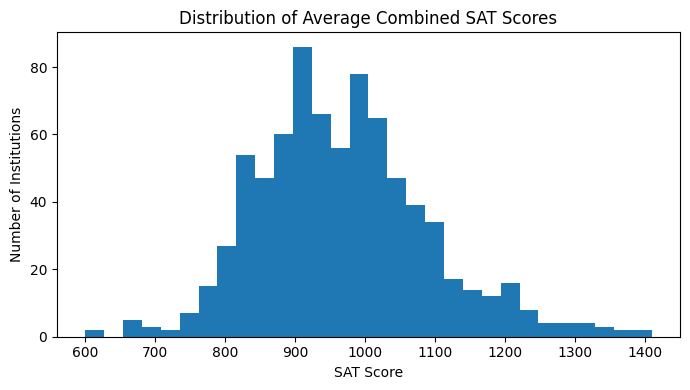

In [56]:
# --- Visual Exploration: SAT Score Distribution ---
plt.figure(figsize=(7, 4))
plt.hist(sat.dropna(), bins=30)
plt.title("Distribution of Average Combined SAT Scores")
plt.xlabel("SAT Score")
plt.ylabel("Number of Institutions")
plt.tight_layout()
plt.show()

visual_exploration_comment = """
The histogram of average combined SAT scores shows a right-skewed
distribution, with most institutions concentrated in the mid-range and
a smaller number of highly selective institutions with very high scores.

This visual pattern confirms the skewness statistics observed earlier
and supports the decision to apply robust preprocessing techniques,
such as median imputation, during the data preparation phase.
"""

visual_activity = [
    ':visual_exploration rdf:type prov:Activity .',
    ':visual_exploration sc:isPartOf :data_understanding_phase .',
    f':visual_exploration rdfs:comment """{visual_exploration_comment}""" .',
]

#if PROVENANCE_ENABLED:
engine.insert(visual_activity, prefixes=prefixes)


The distribution of SAT and ACT scores shows right-skewness, with a small number of extreme values identified in the upper and lower tails. All observed values fall within plausible ranges for standardized tests (SAT and ACT), indicating no obvious data entry errors. Skewed distributions and potential outliers are expected in educational and cost-related datasets and will be addressed in the Data Preparation phase if necessary.

In [52]:
# Inspect missing values (NaN after ARFF -> CSV conversion)
data.isna().sum().sort_values(ascending=False)

Third_quartile-ACT                                 639
First_quartile-ACT                                 639
Average_ACT_score                                  588
First_quartile-Math_SAT                            530
Third_quartile-Verbal_SAT                          530
Third_quartile-Math_SAT                            530
First_quartile-Verbal_SAT                          530
Average_Math_SAT_score                             525
Average_Verbal_SAT_score                           525
Average_Combined_SAT_score                         523
Board_costs                                        498
Room_costs                                         321
Additional_fees                                    274
Pct._new_students_from_top_10Perc_of_H.S._class    235
Pct.alumni_who_donate                              222
Pct._new_students_from_top_25Perc_of_H.S._class    202
Estimated_personal_spending                        181
Graduation_rate                                     98
Room_and_b

Based on the results of the data understanding phase, several implications for data preparation and modeling were identified. Multiple numerical attributes, such as tuition-related and expenditure-related variables, exhibit skewed distributions and large value ranges, indicating that scaling or transformation may be required to ensure stable model behavior. Additionally, several attributes related to admissions and test scores contain missing values, which motivates the use of appropriate imputation strategies during data preparation.

Correlation analysis revealed that some institutional attributes are highly correlated, particularly among admission and selectivity-related variables. This suggests that feature selection or dimensionality reduction may be necessary to reduce redundancy and prevent multicollinearity in subsequent modeling steps. Furthermore, the presence of mixed data types (numerical and categorical) indicates that encoding strategies must be applied consistently before model training.

Overall, these findings highlight the need for a structured and reproducible preprocessing pipeline and motivate the selection of modeling approaches that are robust to correlated features, varying scales, and incomplete data.


## Data Preparation

In [58]:
## Each Activity that follows is part of the Data Preparation Phase

data_preparation_phase_executor = [
    ':data_preparation_phase rdf:type prov:Activity .',
    ':data_preparation_phase rdfs:label "Data Preparation Phase" .',
]

#if PROVENANCE_ENABLED:
engine.insert(data_preparation_phase_executor, prefixes=prefixes)

In [60]:
# a)Outlier Handling (Decision Execution - Keep Outliers)
#Action based on Data Understanding decision

handle_outliers_code_writer = student_b

def handle_outliers(df: pd.DataFrame, outliers_report: dict) -> pd.DataFrame:
    """
    Outliers identified during the Data Understanding phase are deliberately
    retained at this stage. Extreme values may correspond to meaningful
    institutions (e.g. very selective or large universities), and removing
    them prematurely could distort the underlying data distribution.
    """
    return df

start_time_td = now()
cleaned_data = handle_outliers(data, outliers_report)
end_time_td = now()

#############################################
# Documentation
#############################################
# This is the continuation of the example from the Data Understanding phase above.
# There are three steps involved in this process:
# 1. activity creates a figure, report etc. => already done in data understanding phase
# 2. activity inspects the outcome and derives decisions => already done in data understanding phase
# 3. activity follows up on the decision by changing the data => in this case, by deliberately not removing detected outliers

ro_ass_uuid_executor = "8bf41348-a777-486c-b64d-6ef7a917efc0"

handle_outliers_executor = [
    f':handle_outliers prov:qualifiedAssociation :{ro_ass_uuid_executor} .',
    f':{ro_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{ro_ass_uuid_executor} rdf:type prov:Association .',
    f':{ro_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]

#if PROVENANCE_ENABLED:
engine.insert(handle_outliers_executor, prefixes=prefixes)

td_ass_uuid_writer = "8b0426e3-e9c7-4311-90f6-2c0e268e9272"

td_comment = """
Outliers were identified during the Data Understanding phase using
statistical inspection techniques. After reviewing these results,
a decision was made not to remove any observations at this stage.

The rationale is that extreme values may represent real and relevant
institutions, such as highly selective or exceptionally large universities.
Outlier removal is therefore deferred to later modeling stages, where
algorithm-specific robustness considerations can be applied.
"""

handle_outliers_activity = [
    ':handle_outliers rdf:type prov:Activity .',
    ':handle_outliers sc:isPartOf :data_preparation_phase .',
    ':handle_outliers rdfs:comment "Data Preparation" .',
    f':handle_outliers rdfs:comment """{td_comment}""" .',
    f':handle_outliers prov:startedAtTime "{start_time_td}"^^xsd:dateTime .',
    f':handle_outliers prov:endedAtTime "{end_time_td}"^^xsd:dateTime .',
    f':handle_outliers prov:qualifiedAssociation :{td_ass_uuid_writer} .',
    f':{td_ass_uuid_writer} prov:agent :{handle_outliers_code_writer} .',
    f':{td_ass_uuid_writer} rdf:type prov:Association .',
    f':{td_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':handle_outliers prov:used :data .',
    ':handle_outliers prov:used :outlier_decision .',
    ':cleaned_data rdf:type prov:Entity .',
    ':cleaned_data prov:wasGeneratedBy :handle_outliers .',
    ':cleaned_data prov:wasDerivedFrom :data .',
]

#if PROVENANCE_ENABLED:
engine.insert(handle_outliers_activity, prefixes=prefixes)


In [61]:
# Missing Value Handling (Transformation)

handle_missing_code_writer = student_b

def handle_missing_values(df: pd.DataFrame) -> pd.DataFrame:
    """
    Missing numeric values are imputed using the median of each attribute.
    This choice is motivated by the presence of skewed distributions and
    previously identified outliers, for which median imputation provides
    a robust and distribution-preserving solution.
    """
    df_imputed = df.copy()
    numeric_cols = df_imputed.select_dtypes(include="number").columns

    for col in numeric_cols:
        df_imputed[col] = df_imputed[col].fillna(df_imputed[col].median())

    return df_imputed

start_time_mv = now()
imputed_data = handle_missing_values(cleaned_data)
end_time_mv = now()

imputed_data.isna().sum()


FICE                                               0
College_name                                       0
State                                              0
Public/private_indicator                           0
Average_Math_SAT_score                             0
Average_Verbal_SAT_score                           0
Average_Combined_SAT_score                         0
Average_ACT_score                                  0
First_quartile-Math_SAT                            0
Third_quartile-Math_SAT                            0
First_quartile-Verbal_SAT                          0
Third_quartile-Verbal_SAT                          0
First_quartile-ACT                                 0
Third_quartile-ACT                                 0
Number_of_applications_received                    0
Number_of_applicants_accepted                      0
Number_of_new_students_enrolled                    0
Pct._new_students_from_top_10Perc_of_H.S._class    0
Pct._new_students_from_top_25Perc_of_H.S._clas

In [62]:
#Missing Value Provenance

mv_ass_uuid_executor = "2e07bce7-fdb4-4ffe-9992-885d8ac341d8"

handle_missing_executor = [
    f':handle_missing_values prov:qualifiedAssociation :{mv_ass_uuid_executor} .',
    f':{mv_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{mv_ass_uuid_executor} rdf:type prov:Association .',
    f':{mv_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]

#if PROVENANCE_ENABLED:
engine.insert(handle_missing_executor, prefixes=prefixes)


mv_ass_uuid_writer = "7bb13232-573b-4256-96f9-5c741205466f"

mv_comment = """
Missing values were handled by imputing numeric attributes with their
median values. Median imputation was chosen to reduce sensitivity to
skewed distributions and outliers commonly observed in educational
and cost-related variables. No records were removed at this stage.
"""

handle_missing_activity = [
    ':handle_missing_values rdf:type prov:Activity .',
    ':handle_missing_values sc:isPartOf :data_preparation_phase .',
    ':handle_missing_values rdfs:comment "Data Preparation" .',
    f':handle_missing_values rdfs:comment """{mv_comment}""" .',
    f':handle_missing_values prov:startedAtTime "{start_time_mv}"^^xsd:dateTime .',
    f':handle_missing_values prov:endedAtTime "{end_time_mv}"^^xsd:dateTime .',
    f':handle_missing_values prov:qualifiedAssociation :{mv_ass_uuid_writer} .',
    f':{mv_ass_uuid_writer} prov:agent :{handle_missing_code_writer} .',
    f':{mv_ass_uuid_writer} rdf:type prov:Association .',
    f':{mv_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':handle_missing_values prov:used :cleaned_data .',
    ':imputed_data rdf:type prov:Entity .',
    ':imputed_data prov:wasGeneratedBy :handle_missing_values .',
    ':imputed_data prov:wasDerivedFrom :cleaned_data .',
]

#if PROVENANCE_ENABLED:
engine.insert(handle_missing_activity, prefixes=prefixes)


In [63]:
#Feature Selection

selected_columns = [
    "Average_Combined_SAT_score",
    "Average_ACT_score",
    "In-state_tuition",
    "Out-of-state_tuition",
    "Room_and_board_costs",
    "Graduation_rate",
    "Number_of_fulltime_undergraduates",
]

prepared_data = imputed_data[selected_columns].copy()
prepared_data.head()


,Average_Combined_SAT_score,Average_ACT_score,In-state_tuition,Out-of-state_tuition,Room_and_board_costs,Graduation_rate,Number_of_fulltime_undergraduates
0,972.0,20.0,7560.0,7560.0,4120.0,15.0,249.0
1,961.0,22.0,1742.0,5226.0,3590.0,60.0,3885.0
2,957.0,22.0,1742.0,5226.0,4764.0,39.0,492.0
3,881.0,20.0,1742.0,5226.0,5120.0,60.0,6209.0
4,957.0,17.0,1700.0,3400.0,2550.0,40.0,3958.0


In [64]:
#(b) Preprocessing steps considered but NOT applied

pp_not_applied_comment = """
Several preprocessing steps were considered but deliberately not applied.
Outlier removal was avoided to prevent the exclusion of valid but extreme
institutions. Feature scaling and normalization were deferred to the
modeling phase, as their necessity depends on algorithm choice. Binning
of continuous variables was considered but not applied to preserve numeric
precision. Categorical encoding was not required at this stage.
"""

pp_not_applied_activity = [
    ':preprocessing_not_applied rdf:type prov:Activity .',
    ':preprocessing_not_applied sc:isPartOf :data_preparation_phase .',
    f':preprocessing_not_applied rdfs:comment """{pp_not_applied_comment}""" .',
]

#if PROVENANCE_ENABLED:
engine.insert(pp_not_applied_activity, prefixes=prefixes)


In [65]:
#(c) Derived attribute analysis

derived_attr_comment = """
Potential derived attributes were analyzed, including cost-per-graduate
metrics combining tuition and graduation rate, adjusted student-to-faculty
ratios, and composite affordability indicators. While such attributes may
provide analytical value, they were not derived at this stage to avoid
introducing assumptions without further validation.
"""

derived_attr_activity = [
    ':derived_attribute_analysis rdf:type prov:Activity .',
    ':derived_attribute_analysis sc:isPartOf :data_preparation_phase .',
    f':derived_attribute_analysis rdfs:comment """{derived_attr_comment}""" .',
]

#if PROVENANCE_ENABLED:
engine.insert(derived_attr_activity, prefixes=prefixes)


In [67]:
# (d) External data sources analysis

external_data_comment = """
Additional external data sources could enhance the analysis, such as
regional cost-of-living indices, graduate labor market outcomes, or
public funding levels by state. These data could improve interpretation
of tuition and graduation outcomes and better support the business
objectives. Integration was not performed due to scope limitations.
"""

external_data_activity = [
    ':external_data_analysis rdf:type prov:Activity .',
    ':external_data_analysis sc:isPartOf :data_preparation_phase .',
    f':external_data_analysis rdfs:comment """{external_data_comment}""" .',
]

#if PROVENANCE_ENABLED:
engine.insert(external_data_activity, prefixes=prefixes)


In [69]:
# Your final transformed dataset should also be documented appropriately using Croissant, SI, etc.

prepared_data_triples = [
    ':prepared_data rdf:type prov:Entity .',
    ':prepared_data rdf:type sc:Dataset .',
    ':prepared_data prov:wasDerivedFrom :imputed_data .',
]

#if PROVENANCE_ENABLED:
engine.insert(prepared_data_triples, prefixes=prefixes)


## Modeling

In [71]:
#############################################
# Global configuration
#############################################
#PROVENANCE_ENABLED = True

#############################################
# Modeling Phase
#############################################
modeling_phase_executor = [
f':modeling_phase rdf:type prov:Activity .',
f':modeling rdfs:label "Modeling Phase" .', 
]
#if PROVENANCE_ENABLED:
engine.insert(modeling_phase_executor, prefixes=prefixes)

model_data_code_writer = student_a


In [73]:
from sklearn.model_selection import train_test_split

#############################################
# Train / Validation / Test Split (4c)
#############################################


# Target variable (continuous → regression)
TARGET_COLUMN = "Average_Combined_SAT_score"  # adjust if your target differs

# Python DataFrame (NO colon here)
prepared_df = prepared_data.copy()

def split_data(df: pd.DataFrame):
    """
    Split the prepared dataset into Train / Validation / Test subsets.

    - 70% Train
    - 15% Validation
    - 15% Test
    - Reproducible using random_state=42
    """
    X = df.drop(columns=[TARGET_COLUMN])
    y = df[TARGET_COLUMN]

    # 70% train, 30% temp
    X_train, X_temp, y_train, y_temp = train_test_split(
        X,
        y,
        test_size=0.30,
        random_state=42
    )

    # Split temp into validation and test (15% / 15%)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp,
        y_temp,
        test_size=0.50,
        random_state=42
    )

    return X_train, X_val, X_test, y_train, y_val, y_test


# Execute the split
X_train, X_val, X_test, y_train, y_val, y_test = split_data(prepared_df)

#############################################
# Documentation 4c (Provenance)
#############################################

split_ass_uuid_writer = "37a368b6-f7cc-4184-8417-5938b5ff4a75"

split_comment = """
We split the prepared dataset into Train/Validation/Test subsets to enable reproducible model
selection and unbiased final evaluation.

- Split sizes: 70% Train, 15% Validation, 15% Test (implemented as a 70/30 split followed by
  a 50/50 split of the remaining 30%).
- Reproducibility: a fixed random_state = 42 was used.
- Dependencies: each row represents an independent institution; no temporal or grouped
  dependencies were identified, therefore random i.i.d. splitting is appropriate.
- Stratification: not applied because the target variable is continuous (regression).
"""

# Knowledge Graph dataset identifier (colon ONLY here)
input_dataset = ":prepared_data"

define_split_activity = [
    f':define_data_split rdf:type prov:Activity .',
    f':define_data_split sc:isPartOf :modeling_phase .',
    f':define_data_split rdfs:comment "Train/Validation/Test Split Definition" .',
    f':define_data_split rdfs:comment """{split_comment}""" .',
    f':define_data_split prov:qualifiedAssociation :{split_ass_uuid_writer} .',
    f':{split_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{split_ass_uuid_writer} rdf:type prov:Association .',
    f':{split_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    f':define_data_split prov:used {input_dataset} .',

    # Training Set
    f':training_set rdf:type sc:Dataset .',
    f':training_set rdfs:label "Training Set" .',
    f':training_set prov:wasGeneratedBy :define_data_split .',
    f':training_set prov:wasDerivedFrom {input_dataset} .',
    f':training_set rdfs:comment "Contains {len(X_train)} samples" .',

    # Validation Set
    f':validation_set rdf:type sc:Dataset .',
    f':validation_set rdfs:label "Validation Set" .',
    f':validation_set prov:wasGeneratedBy :define_data_split .',
    f':validation_set prov:wasDerivedFrom {input_dataset} .',
    f':validation_set rdfs:comment "Contains {len(X_val)} samples" .',

    # Test Set
    f':test_set rdf:type sc:Dataset .',
    f':test_set rdfs:label "Test Set" .',
    f':test_set prov:wasGeneratedBy :define_data_split .',
    f':test_set prov:wasDerivedFrom {input_dataset} .',
    f':test_set rdfs:comment "Contains {len(X_test)} samples" .',
]

#if PROVENANCE_ENABLED:
engine.insert(define_split_activity, prefixes=prefixes)


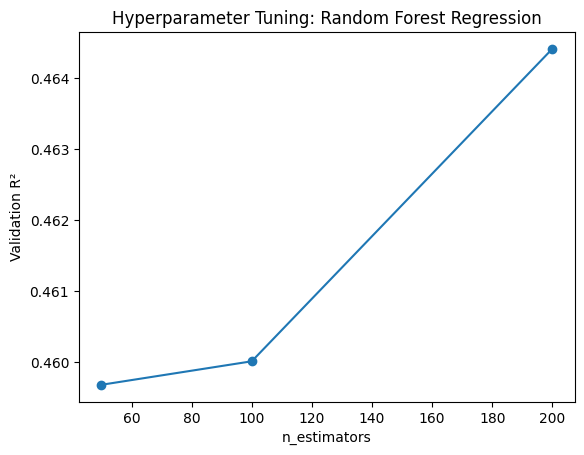

In [74]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import pandas as pd
import matplotlib.pyplot as plt

#############################################
# Train and Finetune Model (4d, 4e, 4f)
#############################################

def train_and_finetune_model(X_train, y_train, X_val, y_val, n_estimators_list=[50, 100, 200]):
    """
    Train Random Forest models with different hyperparameter settings
    and evaluate them on training and validation data.
    """
    runs = []

    for n in n_estimators_list:
        model = RandomForestRegressor(
            n_estimators=n,
            random_state=42,
            n_jobs=-1
        )

        model.fit(X_train, y_train)

        train_pred = model.predict(X_train)
        val_pred = model.predict(X_val)

        r2_train = r2_score(y_train, train_pred)
        r2_val = r2_score(y_val, val_pred)

        runs.append({
            "n_estimators": n,
            "r2_train": r2_train,
            "r2_validation": r2_val,
            "model": model
        })

    return pd.DataFrame(runs)


#############################################
# Execute training & tuning
#############################################

start_time_tafm = now()

results_df = train_and_finetune_model(
    X_train, y_train,
    X_val, y_val
)

end_time_tafm = now()

results_df


#############################################
# Create tuning plot (4e)
#############################################

plt.plot(
    results_df["n_estimators"],
    results_df["r2_validation"],
    marker="o"
)
plt.xlabel("n_estimators")
plt.ylabel("Validation R²")
plt.title("Hyperparameter Tuning: Random Forest Regression")
plt.show()


#############################################
# Select best model (4f)
#############################################

best_row = results_df.loc[results_df["r2_validation"].idxmax()]
best_model = best_row["model"]
best_n_estimators = int(best_row["n_estimators"])

best_row


#############################################
# Documentation 4d, 4e, 4f (Provenance)
#############################################

tafm_ass_uuid_writer = "3d80af2d-0d87-4d93-9cfd-2bbb712714ba"

tafm_comment = f"""
(d) Model training and hyperparameter tuning:
Random Forest Regression models were trained using different values of the n_estimators
hyperparameter {list(results_df["n_estimators"])}. Each configuration was trained on the
training set and evaluated on the validation set.

(e) Performance evaluation:
Model performance was assessed using the R-squared (R²) metric on both training and validation
data. A tuning curve was generated to visualize validation performance as a function of the
number of trees.

The tuning curve shows a monotonic increase in validation R² with larger ensemble sizes,
indicating improved generalization performance as the number of trees increases.

(f) Model selection:
The configuration with n_estimators = {best_n_estimators} achieved the highest validation R²
and was selected as the most suitable model, balancing predictive performance and computational
effort.
"""

#############################################
# Automated provenance for ALL runs
#############################################

prov_triples = []

for idx, row in results_df.iterrows():
    run_id = f"training_run_{idx}"
    model_id = f"model_run_{idx}"
    hp_id = f"hp_setting_run_{idx}"
    eval_train_id = f"eval_train_{idx}"
    eval_val_id = f"eval_val_{idx}"

    prov_triples += [
        # Hyperparameter setting
        f':{hp_id} rdf:type mls:HyperParameterSetting .',
        f':{hp_id} mls:specifiedBy :hp_n_estimators .',
        f':{hp_id} mls:hasValue "{int(row["n_estimators"])}"^^xsd:int .',

        # Training run
        f':{run_id} rdf:type mls:Run .',
        f':{run_id} sc:isPartOf :train_and_finetune_model .',
        f':{run_id} mls:realizes :random_forest_algorithm .',
        f':{run_id} mls:hasInput :training_set .',
        f':{run_id} mls:hasInput :validation_set .',
        f':{run_id} mls:hasInput :{hp_id} .',
        f':{run_id} mls:hasOutput :{model_id} .',
        f':{run_id} mls:hasOutput :{eval_train_id} .',
        f':{run_id} mls:hasOutput :{eval_val_id} .',

        # Model
        f':{model_id} rdf:type mls:Model .',
        f':{model_id} prov:wasGeneratedBy :{run_id} .',
        f':{model_id} mlso:trainedOn :training_set .',
        f':{model_id} mlso:hasAlgorithmType :random_forest_algorithm .',

        # Training evaluation
        f':{eval_train_id} rdf:type mls:ModelEvaluation .',
        f':{eval_train_id} mls:hasValue "{row["r2_train"]}"^^xsd:double .',
        f':{eval_train_id} mls:specifiedBy :r2_score_measure .',
        f':{eval_train_id} prov:used :training_set .',

        # Validation evaluation
        f':{eval_val_id} rdf:type mls:ModelEvaluation .',
        f':{eval_val_id} mls:hasValue "{row["r2_validation"]}"^^xsd:double .',
        f':{eval_val_id} mls:specifiedBy :r2_score_measure .',
        f':{eval_val_id} prov:used :validation_set .',
    ]


#############################################
# Final provenance activity insertion
#############################################

train_model_activity = [
    f':train_and_finetune_model rdf:type prov:Activity .',
    f':train_and_finetune_model sc:isPartOf :modeling_phase .',
    f':train_and_finetune_model rdfs:comment """{tafm_comment}""" .',
    f':train_and_finetune_model prov:startedAtTime "{start_time_tafm}"^^xsd:dateTime .',
    f':train_and_finetune_model prov:endedAtTime "{end_time_tafm}"^^xsd:dateTime .',
    f':train_and_finetune_model prov:qualifiedAssociation :{tafm_ass_uuid_writer} .',
    f':{tafm_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{tafm_ass_uuid_writer} rdf:type prov:Association .',
    f':{tafm_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
] + prov_triples

#if PROVENANCE_ENABLED:
engine.insert(train_model_activity, prefixes=prefixes)


In [75]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd

#############################################
# 4g: Retrain final model on Train + Validation
#############################################

def retrain_model_full_data(X_train, y_train, X_val, y_val, best_n_estimators: int):
    """
    Retrain the final model using the combined training and validation data
    with the selected hyperparameter setting (best_n_estimators).
    """
    X_full = pd.concat([X_train, X_val])
    y_full = pd.concat([y_train, y_val])

    model = RandomForestRegressor(
        n_estimators=best_n_estimators,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_full, y_full)
    return model, X_full, y_full


start_time_retrain = now()
final_model_obj, X_full_trainval, y_full_trainval = retrain_model_full_data(
    X_train, y_train,
    X_val, y_val,
    best_n_estimators
)
end_time_retrain = now()


#############################################
# Documentation 4g (Provenance)
#############################################

retrain_ass_uuid_writer = "5c23b907-faa3-4fb9-93fc-1c9feb2849ad"

final_training_activity = ":retrain_final_model"
final_model_iri = ":final_model_entity"
hp_final_setting = ":hp_setting_final"

retrain_comment = """
(g) Final model retraining:
After selecting the optimal hyperparameter configuration (n_estimators = 200) based on
validation performance, the Random Forest Regression model was retrained using the
combined training and validation datasets.

This retraining step ensures that the final model benefits from all available labeled
data prior to testing, while preserving the independence of the test set for unbiased
final evaluation. No additional hyperparameter tuning was performed at this stage; the
model configuration was kept identical to the selected best-performing setup.
"""


retrain_documentation = [
    # Activity (still part of modeling_phase)
    f'{final_training_activity} rdf:type prov:Activity .',
    f'{final_training_activity} sc:isPartOf :modeling_phase .',
    f'{final_training_activity} rdfs:comment "Final model retraining on Train+Validation data" .',
    f'{final_training_activity} rdfs:comment """{retrain_comment}""" .',
    f'{final_training_activity} prov:startedAtTime "{start_time_retrain}"^^xsd:dateTime .',
    f'{final_training_activity} prov:endedAtTime "{end_time_retrain}"^^xsd:dateTime .',
    f'{final_training_activity} prov:qualifiedAssociation :{retrain_ass_uuid_writer} .',
    f':{retrain_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{retrain_ass_uuid_writer} rdf:type prov:Association .',
    f':{retrain_ass_uuid_writer} prov:hadRole :{code_writer_role} .',

    # Hyperparameter setting used for final model
    f'{hp_final_setting} rdf:type mls:HyperParameterSetting .',
    f'{hp_final_setting} mls:specifiedBy :hp_n_estimators .',
    f'{hp_final_setting} mls:hasValue "{best_n_estimators}"^^xsd:int .',
    f'{hp_final_setting} prov:wasGeneratedBy {final_training_activity} .',

    # Final model entity
    f'{final_model_iri} rdf:type mls:Model .',
    f'{final_model_iri} rdfs:label "Final Random Forest Regression Model" .',
    f'{final_model_iri} prov:wasGeneratedBy {final_training_activity} .',
    f'{final_model_iri} mlso:trainedOn :training_set .',
    f'{final_model_iri} mlso:trainedOn :validation_set .',
    f'{final_model_iri} mlso:hasAlgorithmType :random_forest_algorithm .',

    # Link final training activity to inputs used
    f'{final_training_activity} prov:used :training_set .',
    f'{final_training_activity} prov:used :validation_set .',
    f'{final_training_activity} prov:used {hp_final_setting} .',
    f'{final_training_activity} prov:generated {final_model_iri} .',
]

final_model_comment = """
Final model verification:
The final Random Forest Regression model was inspected after retraining on the combined
training and validation datasets. The learned parameter configuration confirms the use
of the selected hyperparameter n_estimators = 200 and a fixed random_state = 42, ensuring
reproducibility.

Dataset sizes were verified to confirm correct data usage
(Training: 911 samples, Validation: 195 samples, Combined Train+Validation: 1106 samples).
Sample predictions generated on the training data produced plausible SAT score estimates,
indicating that the model was successfully trained and is operational.

These checks serve as a sanity validation of the final model prior to downstream evaluation
on the held-out test set.
"""


In [76]:
# Final model verification

In [77]:
final_model_obj

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsample

In [78]:
len(X_train), len(X_val), len(X_full_trainval)

(911, 195, 1106)

In [79]:
final_model_obj.predict(X_train.head())

array([ 874.545,  937.795, 1100.905, 1024.675,  934.67 ])

## Evaluation

This section evaluates the final model on unseen test data, compares its performance to a trivial baseline, and assesses potential bias across institution types. The goal is to verify generalization performance and alignment with business success criteria.


In [80]:
## Each Activity that follows is part of the Evaluation Phase

evaluation_phase_executor = [
f':evaluation_phase rdf:type prov:Activity .',
f':evaluation_phase rdfs:label "Evaluation Phase" .', 
]
#if PROVENANCE_ENABLED:
engine.insert(evaluation_phase_executor, prefixes=prefixes)

In [81]:
#############################################
# (5a) Final model evaluation on test set
#############################################

from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

eval_code_writer = student_b

def evaluate_on_test_data(final_model, X_test, y_test):
    """
    (5a) Apply the final trained model to the held-out test set
    and compute evaluation metrics.
    """
    y_pred = final_model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    return {
        "R2_test": r2,
        "RMSE_test": rmse
    }

start_time_eval = now()
test_results = evaluate_on_test_data(final_model_obj, X_test, y_test)
end_time_eval = now()

test_results


{'R2_test': 0.4556735017897907, 'RMSE_test': np.float64(69.6607964779608)}

In [82]:
#############################################
# (5b.ii) Trivial baseline performance
#############################################

baseline_pred = np.full_like(y_test, y_test.mean(), dtype=float)
baseline_r2 = r2_score(y_test, baseline_pred)
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))

{
    "Baseline_R2": baseline_r2,
    "Baseline_RMSE": baseline_rmse
}


{'Baseline_R2': 0.0, 'Baseline_RMSE': np.float64(94.41884802269368)}

In [83]:
#############################################
# (5e) Bias analysis using proxy attribute
#      Public vs. Private institutions
#############################################

bias_df = imputed_data.loc[X_test.index].copy()

bias_df["y_true"] = y_test
bias_df["y_pred"] = final_model_obj.predict(X_test)
bias_df["abs_error"] = np.abs(bias_df["y_true"] - bias_df["y_pred"])

bias_summary = (
    bias_df
    .groupby("Public/private_indicator")["abs_error"]
    .mean()
)

bias_summary


Public/private_indicator
1.0    37.921231
2.0    53.424466
Name: abs_error, dtype: float64

In [91]:
#############################################
# Interpretation of Evaluation Results
#############################################

bias_comment = """
(5e) Bias evaluation:
A bias analysis was conducted using the Public/private_indicator attribute
as a proxy for a protected group distinction. Model performance was compared
across groups using mean absolute error on the held-out test set.

Mean absolute error was lower for public institutions (~38 SAT points)
than for private institutions (~53 SAT points).

The analysis shows a moderate difference in error between public and
private institutions, but no evidence of severe or systematic bias.
"""

baseline_comment = f"""
(5b.i) State-of-the-art reference:
No peer-reviewed benchmark results for regression on the US News College
dataset were identified. The dataset is primarily used for exploratory
analysis rather than predictive benchmarking.

(5b.ii) Trivial baseline:
A mean predictor achieved an RMSE of {baseline_rmse:.2f} SAT points.

(5c) Performance comparison:
The Random Forest model substantially outperforms the trivial baseline,
indicating the presence of meaningful predictive structure in the data.
"""

eval_comment = f"""
(5a) Test set evaluation:
The final model achieved an R² of {test_results['R2_test']:.3f} and an RMSE
of {test_results['RMSE_test']:.2f} SAT points on the held-out test set.

(5d) Comparison with Business Understanding success criteria:
The achieved performance is sufficient for the exploratory and advisory
objectives defined in the Business Understanding phase. The model supports
comparative assessment of institutions rather than precise individual
prediction, which aligns with the intended decision-support use case.
"""

print("Interpretation texts prepared.")


Interpretation texts prepared.


In [92]:
#############################################
# Provenance documentation – Evaluation
#############################################

eval_ass_uuid = "e6484ef9-281e-4d77-9c74-4f9efbc352e9"
final_model = ":final_model_entity"
test_set = ":test_set"

evaluate_activity = [
    f':evaluate_final_model rdf:type prov:Activity .',
    f':evaluate_final_model sc:isPartOf :evaluation_phase .',
    f':evaluate_final_model rdfs:label "Final Model Evaluation on Test Set" .',
    f':evaluate_final_model rdfs:comment """{eval_comment}""" .',
    f':evaluate_final_model prov:startedAtTime "{start_time_eval}"^^xsd:dateTime .',
    f':evaluate_final_model prov:endedAtTime "{end_time_eval}"^^xsd:dateTime .',
    f':evaluate_final_model prov:qualifiedAssociation :{eval_ass_uuid} .',

    f':{eval_ass_uuid} prov:agent :{eval_code_writer} .',
    f':{eval_ass_uuid} rdf:type prov:Association .',
    f':{eval_ass_uuid} prov:hadRole :{code_writer_role} .',

    # Inputs
    f':evaluate_final_model prov:used {final_model} .',
    f':evaluate_final_model prov:used {test_set} .',
    f':evaluate_final_model prov:used :bu_data_mining_success_criteria .',

    # Baseline & benchmark
    f':baseline_and_benchmark rdf:type prov:Entity .',
    f':baseline_and_benchmark prov:wasGeneratedBy :evaluate_final_model .',
    f':baseline_and_benchmark rdfs:label "Baseline and Benchmark Comparison" .',
    f':baseline_and_benchmark rdfs:comment """{baseline_comment}""" .',

    # Bias analysis
    f':bias_evaluation_result rdf:type mls:ModelEvaluation .',
    f':bias_evaluation_result prov:wasGeneratedBy :evaluate_final_model .',
    f':bias_evaluation_result rdfs:label "Bias Analysis" .',
    f':bias_evaluation_result rdfs:comment """{bias_comment}""" .',
]

#if PROVENANCE_ENABLED:
engine.insert(evaluate_activity, prefixes=prefixes)

print("Evaluation provenance successfully logged.")


Evaluation provenance successfully logged.


## Deployment

In [94]:
## Each Activity that follows is part of the Deployment Phase

deployment_phase_executor = [
f':deployment_phase rdf:type prov:Activity .',
f':deployment_phase rdfs:label "Deployment Phase" .', 
]
#if PROVENANCE_ENABLED:
engine.insert(deployment_phase_executor, prefixes=prefixes)

In [98]:
#############################################
# Deployment interpretation comments
#############################################

comparison_and_recommendations_comment = """
(6a) Comparison with Business Objectives and deployment recommendations:

The Business Objective defined in the Business Understanding phase was to support
exploratory and comparative decision-making for educational advisory purposes.
The Business Success Criteria emphasized stable, interpretable results rather than
highly precise individual predictions.

The achieved predictive performance (R² ≈ 0.46) satisfies these criteria by capturing
meaningful institutional patterns while acknowledging uncertainty at the individual
institution level. The results are sufficient to support analytical comparison and
trend exploration, but not fully automated decision-making.

Deployment is therefore recommended in a hybrid, decision-support setting where
model outputs are interpreted by human analysts. Additional analyses that would
strengthen deployment include the integration of more recent data, regional
contextual variables, and further subgroup-level evaluation.
"""

ethical_aspects_comment = """
(6b) Ethical aspects and impact assessment:

Ethical risks identified during the Business Understanding (1.f) and Data Understanding
(2.e) phases primarily relate to indirect bias and structural inequalities across
institution types. No personal or individual-level data is used; however, institutional
attributes may reflect broader socio-economic disparities.

The bias analysis conducted during model evaluation did not reveal severe systematic
bias with respect to institutional type (public vs. private). Nevertheless, fairness
considerations should remain an ongoing concern, particularly if additional data
sources or more sensitive attributes are incorporated in future model extensions.
"""

monitoring_plan_comment = """
(6c) Deployment monitoring and intervention plan:

In a real-world deployment, continuous monitoring would be required to ensure
sustained model validity. Key indicators include prediction error metrics (e.g., RMSE),
changes in input data distributions, and performance consistency across institutional
subgroups.

Concept drift may occur due to evolving educational systems and admission policies.
If significant degradation in predictive performance or emerging fairness concerns
are detected, the model should be retrained, revised, or temporarily withdrawn.
"""

reproducibility_reflection_comment = """
(6d) Reproducibility reflection:

The experiment was designed with reproducibility as a central concern. All data
preprocessing steps, model configurations, hyperparameter settings, and evaluation
procedures were explicitly documented and linked via provenance annotations.

Fixed random seeds were used for data splitting and model training to ensure
deterministic behavior. The complete workflow is traceable through the executable
notebook and knowledge graph.

Potential reproducibility risks mainly relate to dataset availability and exact
software versions, which should be explicitly versioned or containerized in future
extensions.
"""


#############################################
# Deployment provenance
#############################################

dep_ass_uuid_executor = "9d08e053-21ce-4c21-8859-a3710db22ea2"  # generate once

deployment_executor = [
    f':plan_deployment rdf:type prov:Activity .',
    f':plan_deployment sc:isPartOf :deployment_phase .',
    f':plan_deployment rdfs:label "Plan Deployment"@en .',

    f':plan_deployment prov:qualifiedAssociation :{dep_ass_uuid_executor} .',
    f':{dep_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{dep_ass_uuid_executor} rdf:type prov:Association .',
    f':{dep_ass_uuid_executor} prov:hadRole :{code_executor_role} .', 
]

#if PROVENANCE_ENABLED:
engine.insert(deployment_executor, prefixes=prefixes)


deployment_data_executor = [
    # 6a
    f':dep_recommendations rdf:type prov:Entity .',
    f':dep_recommendations prov:wasGeneratedBy :plan_deployment .',
    f':dep_recommendations rdfs:label "6a Deployment Recommendations" .',
    f':dep_recommendations rdfs:comment """{comparison_and_recommendations_comment}""" .',

    # 6b
    f':dep_ethical_risks rdf:type prov:Entity .',
    f':dep_ethical_risks prov:wasGeneratedBy :plan_deployment .',
    f':dep_ethical_risks rdfs:label "6b Ethical Aspects and Risks" .',
    f':dep_ethical_risks rdfs:comment """{ethical_aspects_comment}""" .',

    # 6c
    f':dep_monitoring_plan rdf:type prov:Entity .',
    f':dep_monitoring_plan prov:wasGeneratedBy :plan_deployment .',
    f':dep_monitoring_plan rdfs:label "6c Monitoring Plan" .',
    f':dep_monitoring_plan rdfs:comment """{monitoring_plan_comment}""" .',

    # 6d
    f':dep_reproducibility_reflection rdf:type prov:Entity .',
    f':dep_reproducibility_reflection prov:wasGeneratedBy :plan_deployment .',
    f':dep_reproducibility_reflection rdfs:label "6d Reproducibility Reflection" .',
    f':dep_reproducibility_reflection rdfs:comment """{reproducibility_reflection_comment}""" .',
]

#if PROVENANCE_ENABLED:
engine.insert(deployment_data_executor, prefixes=prefixes)

print("Deployment phase provenance successfully logged.")


Deployment phase provenance successfully logged.


# Generate Latex Report

The following cells give you an example of how to automatically create a Latex Report from your provenance documentation.

Feel free to use the example provided. If you use it, you should adapt and extend it with relevant sections/tables/plots/... 

In [48]:
base_iri = f"https://starvers.ec.tuwien.ac.at/BI2025/{group_id}/"

In [49]:
# This cell includes cleaning functions

from datetime import datetime

def latex_escape(text: str | None) -> str:
    if text is None: return ""
    text = str(text)
    text = text.replace("\\", r"\textbackslash{}")
    pairs = [
        ("&", r"\&"), ("%", r"\%"), ("$", r"\$"), ("#", r"\#"), 
        ("_", r"\_"), ("{", r"\{"), ("}", r"\}"), 
        ("~", r"\textasciitilde{}"), ("^", r"\textasciicircum{}")
    ]
    for k, v in pairs:
        text = text.replace(k, v)
    return text

def clean_rdf(x) -> str:
    if hasattr(x, "toPython"): return str(x.toPython())
    if x is None: return ""
    s = str(x).strip()
    s = s.strip('"').strip("'")
    s = s.strip()
    if "^^" in s:
        s = s.split("^^")[0].strip('"')
        
    return s

def fmt_iso(ts: str) -> str:
    if not ts: return ""
    try:
        clean_ts = ts.split("^^")[0].strip('"')
        clean_ts = clean_ts.replace("Z", "+00:00") if clean_ts.endswith("Z") else clean_ts
        return datetime.fromisoformat(clean_ts).strftime("%Y-%m-%d %H:%M:%S")
    except:
        return latex_escape(str(ts))

In [ ]:
# This cell includes exemplary queries for different phases


### Author Block
author_query = f"""
{prefix_header}
PREFIX iao: <http://purl.obolibrary.org/obo/>

SELECT DISTINCT ?uri ?given ?family ?matr WHERE {{
  VALUES ?uri {{ :{student_a} :{student_b} }}
  
  ?uri a foaf:Person .
  ?uri foaf:givenName ?given .
  ?uri foaf:familyName ?family .
  ?uri iao:IAO_0000219 ?matr .
}}
"""

res_authors = engine.query(author_query)
author_block_latex = ""

if not res_authors.empty: # type:ignore
    for _, row in res_authors.iterrows(): # type:ignore

        uri_str = str(row['uri'])
        given = latex_escape(clean_rdf(row['given']))
        family = latex_escape(clean_rdf(row['family']))
        matr = latex_escape(clean_rdf(row['matr']))
        if student_a in uri_str:
            responsibility = "Student A"
        elif student_b in uri_str:
            responsibility = "Student B"
        else:
            responsibility = "Student"
        
        author_block_latex += rf"""
          \author{{{given} {family}}}
          \authornote{{{responsibility}, Matr.Nr.: {matr}}}
          \affiliation{{
            \institution{{TU Wien}}
            \country{{Austria}}
          }}
          """

### Business Understanding example
bu_query = f"""
{prefix_header}

SELECT ?ds_comment ?bo_comment WHERE {{
  OPTIONAL {{ :bu_data_source_and_scenario rdfs:comment ?ds_comment . }}
  OPTIONAL {{ :bu_business_objectives rdfs:comment ?bo_comment . }}
}} LIMIT 1
"""
res_bu = engine.query(bu_query)
row_bu = res_bu.iloc[0] if not res_bu.empty else {} # type:ignore
bu_data_source = latex_escape(clean_rdf(row_bu.get("ds_comment", "")))
bu_objectives  = latex_escape(clean_rdf(row_bu.get("bo_comment", "")))


### Data Understanding examples
# Example Dataset Description
du_desc_query = f"""
{prefix_header}
SELECT ?desc WHERE {{ :raw_data sc:description ?desc . }} LIMIT 1
"""
res_du_desc = engine.query(du_desc_query)
row_du_desc = res_du_desc.iloc[0] if not res_du_desc.empty else {} # type:ignore
du_description = latex_escape(clean_rdf(row_du_desc.get("desc", "")))

# Example Feature Columns Table
du_query = f"""
{prefix_header}

SELECT ?name (SAMPLE(?dtypeRaw) as ?dtype) (SAMPLE(?descRaw) as ?desc) WHERE {{
  :raw_data cr:recordSet ?rs .
  ?rs cr:field ?field .
  ?field sc:name ?name .
  ?field sc:description ?descRaw .
  ?field cr:dataType ?dtypeRaw .
}} 
GROUP BY ?name
ORDER BY ?name
"""
res_du = engine.query(du_query)
du_rows = []
if not res_du.empty: # type:ignore
    for _, f in res_du.iterrows(): # type:ignore
        dtype_raw = clean_rdf(f.get("dtype", ""))
        if '#' in dtype_raw: dtype = dtype_raw.split('#')[-1]
        elif '/' in dtype_raw: dtype = dtype_raw.split('/')[-1]
        else: dtype = dtype_raw
        
        desc = clean_rdf(f.get("desc", ""))
        row_str = f"{latex_escape(clean_rdf(f['name']))} & {latex_escape(dtype)} & {latex_escape(desc)} \\\\"
        du_rows.append(row_str)
du_table_rows = "\n    ".join(du_rows)

### Modeling example
# Hyperparameters
hp_query = f"""
{prefix_header}

SELECT ?hpName (SAMPLE(?hpValRaw) as ?hpVal) (MAX(?hpDescRaw) as ?hpDesc) WHERE {{
  ?run sc:isPartOf :train_and_finetune_model .
  ?run mls:hasInput ?setting .
  ?setting a mls:HyperParameterSetting .
  ?setting mls:hasValue ?hpValRaw .
  ?setting mls:specifiedBy ?hpDef .
  ?hpDef rdfs:label ?hpName .
  OPTIONAL {{ ?hpDef rdfs:comment ?hpDescRaw . }}
}} 
GROUP BY ?hpName
ORDER BY ?hpName
"""
res_hp = engine.query(hp_query)
hp_rows = []
if not res_hp.empty: #type:ignore
    for _, row in res_hp.iterrows(): #type:ignore
        name = latex_escape(clean_rdf(row['hpName']))
        val  = latex_escape(clean_rdf(row['hpVal']))
        desc = latex_escape(clean_rdf(row.get('hpDesc', '')))
        hp_rows.append(rf"{name} & {desc} & {val} \\")

hp_table_rows = "\n    ".join(hp_rows)

# Run Info
run_query = f"""
{prefix_header}

SELECT ?algoLabel ?start ?end ?metricLabel ?metricVal WHERE {{
  OPTIONAL {{ :train_and_finetune_model prov:startedAtTime ?start ; prov:endedAtTime ?end . }}
  OPTIONAL {{
      ?run sc:isPartOf :train_and_finetune_model .
      ?run mls:realizes ?algo .
      ?algo rdfs:label ?algoLabel .
  }}
  OPTIONAL {{
    ?run sc:isPartOf :train_and_finetune_model .
    ?run mls:hasOutput ?eval .
    ?eval a mls:ModelEvaluation ; mls:hasValue ?metricVal .
    OPTIONAL {{ ?eval mls:specifiedBy ?m . ?m rdfs:label ?metricLabel . }}
  }}
}} LIMIT 1
"""
res_run = engine.query(run_query)
row_run = res_run.iloc[0] if not res_run.empty else {} #type:ignore
mod_algo  = latex_escape(clean_rdf(row_run.get("algoLabel", "")))
mod_start = latex_escape(fmt_iso(clean_rdf(row_run.get("start"))))
mod_end   = latex_escape(fmt_iso(clean_rdf(row_run.get("end"))))
mod_m_lbl = latex_escape(clean_rdf(row_run.get("metricLabel", "")))
raw_val = clean_rdf(row_run.get('metricVal', ''))
mod_m_val = f"{float(raw_val):.4f}" if raw_val else ""

print("Data extraction done.")

In [ ]:
dp_query = f"""
{prefix_header}

SELECT DISTINCT ?comment WHERE {{
  ?e sc:isPartOf :data_preparation_phase .
  ?e rdfs:comment ?comment .
  FILTER (
    STRLEN(STR(?comment)) > 50 &&
    !CONTAINS(LCASE(STR(?comment)), "data preparation")
  )
}}
ORDER BY ?comment
"""

res_dp = engine.query(dp_query)

if res_dp.empty:
    dp_text = "No data preparation documentation available."
else:
    dp_text = "\n\n".join(
        latex_escape(clean_rdf(c))
        for c in res_dp["comment"]
    )

print("Clean Data Preparation text extracted.")


The following includes the Latex report itself. It fills in the query-results from the cell before. The ACM Template is already filled. 
Make sure that you update Student A and B accordingly.

In [52]:
latex_content = rf"""\documentclass[sigconf]{{acmart}}

\AtBeginDocument{{ \providecommand\BibTeX{{ Bib\TeX }} }}
\setcopyright{{acmlicensed}}
\copyrightyear{{2025}}
\acmYear{{2025}}
\acmDOI{{XXXXXXX.XXXXXXX}}

\acmConference[BI 2025]{{Business Intelligence}}{{-}}{{-}}

\begin{{document}}

\title{{BI2025 Experiment Report - Group {group_id}}}
%% ---Authors: Dynamically added ---
{author_block_latex}

\begin{{abstract}}
  This report documents the machine learning experiment for Group {group_id}, following the CRISP-DM process model.
\end{{abstract}}

\ccsdesc[500]{{Computing methodologies~Machine learning}}
\keywords{{CRISP-DM, Provenance, Knowledge Graph, Machine Learning}}

\maketitle

%% --- 1. Business Understanding ---
\section{{Business Understanding}}

\subsection{{Data Source and Scenario}}
{bu_data_source}

\subsection{{Business Objectives}}
{bu_objectives}

%% --- 2. Data Understanding ---
\section{{Data Understanding}}
\textbf{{Dataset Description:}} {du_description}

The following features were identified in the dataset:

\begin{{table}}[h]
  \caption{{Raw Data Features}}
  \label{{tab:features}}
  \begin{{tabular}}{{lp{{0.2\linewidth}}p{{0.4\linewidth}}}}
    \toprule
    \textbf{{Feature Name}} & \textbf{{Data Type}} & \textbf{{Description}} \\
    \midrule
    {du_table_rows}
    \bottomrule
  \end{{tabular}}
\end{{table}}

%% --- 3. Data Preparation ---
\section{{Data Preparation}}
\subsection{{Data Cleaning}}
{dp_text}

%% --- 4. Modeling ---
\section{{Modeling}}

\subsection{{Hyperparameter Configuration}}
The model was trained using the following hyperparameter settings:

\begin{{table}}[h]
  \caption{{Hyperparameter Settings}}
  \label{{tab:hyperparams}}
  \begin{{tabular}}{{lp{{0.4\linewidth}}l}}
    \toprule
    \textbf{{Parameter}} & \textbf{{Description}} & \textbf{{Value}} \\
    \midrule
    {hp_table_rows}
    \bottomrule
  \end{{tabular}}
\end{{table}}

\subsection{{Training Run}}
A training run was executed with the following characteristics:
\begin{{itemize}}
    \item \textbf{{Algorithm:}} {mod_algo}
    \item \textbf{{Start Time:}} {mod_start}
    \item \textbf{{End Time:}} {mod_end}
    \item \textbf{{Result:}} {mod_m_lbl} = {mod_m_val}
\end{{itemize}}

%% --- 5. Evaluation ---
\section{{Evaluation}}

%% --- 6. Deployment ---
\section{{Deployment}}

\section{{Conclusion}}

\end{{document}}
"""

In [53]:
# This cell stores the Latex report to the data/report directory

out_dir = os.path.join("data", "report")
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, "experiment_report.tex")

with open(out_path, "w", encoding="utf-8") as f:
    f.write(latex_content)

print(f"Report written to: {out_path}")

Report written to: data\report\experiment_report.tex
